In [2]:
import pandas as pd

train_path = "Chest/ChestNew/trainfiltered.csv"
test_path = "Chest/ChestNew/testfiltered.csv"
image_folder = "Chest/ChestNew/"


train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df = train_df[["Name", "class_id"]]
test_df = test_df[["Name", "class_id"]]


train_df


,Name,class_id
0,2202341086,1
1,2307410255,1
2,2302394915,1
3,2408458946,1
4,2306409371,1
...,...,...
791,2402436028,0
792,2402436030,0
793,2402436038,0
794,2402436122,0


In [3]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform_aug=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform_aug = transform_aug
        self.raw_tensor = T.ToTensor()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, "Name"]
        label = int(self.dataframe.loc[idx, "class_id"])

        # Full path ke gambar
        img_path = os.path.join(self.image_folder, str(img_name) + ".png")

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

            image = Image.new("RGB", (224, 224), (0, 0, 0))

        x_input, x_raw = self.transform_aug(image)

        return x_input, x_raw, torch.tensor(label, dtype=torch.long)


In [4]:
import albumentations as A
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import torchvision.transforms as T
import cv2
from PIL import Image
import numpy as np

class CombinedAugmentation:
    def __init__(self):
        self.albumentations_transform = A.Compose([
            A.Resize(224, 224),\
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.8),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.5),
            A.MotionBlur(p=0.2)
            
        ])

        self.norm = A.Normalize(mean=(0.5,), 
                                std=(0.5,))
        
        self.to_tensor = ToTensorV2()

        self.torch_transform = T.Compose([
            # Augmentasi tambahan setelah tensor (opsional)
            T.RandomErasing(p=0.3, scale=(0.02, 0.2))
        ])

    def __call__(self, img_pil):
        img = np.array(img_pil)

        augmented = self.albumentations_transform(image=img)['image']

        img_raw = T.ToTensor()(Image.fromarray(augmented))

        normed = self.norm(image=augmented)['image']

        tensor_normed = self.to_tensor(image=normed)['image']
        
        return tensor_normed, img_raw
    




c:\Users\BDSRC\miniconda3\envs\ViTlung\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
# Inisialisasi transform gabungan
train_transform = CombinedAugmentation()

# Dataset & Dataloader
train_dataset = ChestXrayDataset(train_df, image_folder, transform_aug=train_transform)
test_dataset = ChestXrayDataset(test_df, image_folder, transform_aug=train_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


c:\Users\BDSRC\miniconda3\envs\ViTlung\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_15396\961393361.py:18: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.5),


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

class VAE_Classifier(nn.Module):
    def __init__(self, latent_dim=64, num_classes=2, input_size=(3, 224, 224)):
        super(VAE_Classifier, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        self.encoder_local = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1
        )

        self.encoder_global = nn.Sequential(
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )

        self.pool_local = nn.AdaptiveAvgPool2d((1, 1))
        self.pool_global = nn.AdaptiveAvgPool2d((1, 1))

        # Hitung flatten_dim secara dinamis
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            local_out = self.encoder_local(dummy_input)
            global_out = self.encoder_global(local_out)

            pooled_local = self.pool_local(local_out)
            pooled_global = self.pool_global(global_out)

            flat_local = torch.flatten(pooled_local, start_dim=1)
            flat_global = torch.flatten(pooled_global, start_dim=1)

            self.flatten_dim = flat_local.shape[1] + flat_global.shape[1] 
            self.decoder_input_shape = pooled_global.shape[1:]  # (C, H, W)

        print(f"flatten_dim: {self.flatten_dim}")

        # Encoder output ke latent space
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder dari latent ke feature map
        self.decoder_fc = nn.Linear(latent_dim, 512 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 7, 7)),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )


        # Classifier dari latent space
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, num_classes)
        )

    def reparameterize(self, mu, logvar, deterministic=False):
        if deterministic:
            return mu
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std

    def forward(self, x, deterministic=False):
        x_local = self.encoder_local(x)
        x_global = self.encoder_global(x_local)

        pooled_local = self.pool_local(x_local)
        pooled_global = self.pool_global(x_global)

        flat_local = torch.flatten(pooled_local, start_dim=1)
        flat_global = torch.flatten(pooled_global, start_dim=1)

        x_flat = torch.cat([flat_local, flat_global], dim=1)

        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        logvar = torch.clamp(logvar, min=-10, max=10)

        z = self.reparameterize(mu, logvar, deterministic=deterministic)
        
        x_recon = self.decoder_fc(z)
        x_recon = self.decoder(x_recon)
        y_pred = self.classifier(z)
        
        return x_recon, mu, logvar, y_pred

def loss_function(x_recon, x, mu, logvar, y_pred, y_true, alpha=1.0, beta=0.0001, gamma=2.0):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) 
    class_loss = nn.functional.cross_entropy(y_pred, y_true)
    
    # Debug print (aktifkan sementara)
    print(f"recon: {recon_loss.item():.4f}, kl: {kl_loss.item():.4f}, cls: {class_loss.item():.4f}")
    
    return alpha * recon_loss + beta * kl_loss + gamma * class_loss


In [ ]:
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import precision_score, recall_score, f1_score
import wandb
import torch

wandb.init(
    project="vae-classifier-lung",
    name="vae_resnet50_run1",
    config={
        "learning_rate": 1e-4,
        "epochs": 200,
        "latent_dim": 512,
        "batch_size": 32,
        "weight_decay": 1e-5,
        "model": "VAE_Classifier_resnet50"
    }
)

scaler = GradScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_Classifier(latent_dim=512, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# --- Training Loop ---
def train(model, loader, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x_input, x_raw, labels in tqdm(loader, desc="Training"):
        x_input, x_raw, labels = x_input.to(device), x_raw.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            x_recon, mu, logvar, y_pred = model(x_input)
            recon_loss = nn.functional.binary_cross_entropy_with_logits(x_recon, x_raw, reduction='mean')
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) / x_input.size(0)
            class_loss = nn.functional.cross_entropy(y_pred, labels)
            loss = recon_loss + 0.0001 * kl_loss + class_loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        running_loss += loss.item() * x_input.size(0)
        preds = torch.argmax(y_pred, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# --- Validation Loop ---
def validate(model, loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_input, x_raw, labels in tqdm(loader, desc="Validation"):
            x_input, x_raw, labels = x_input.to(device), x_raw.to(device), labels.to(device)

            with autocast():
                x_recon, mu, logvar, y_pred = model(x_input)
                recon_loss = nn.functional.binary_cross_entropy_with_logits(x_recon, x_raw, reduction='mean')
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) / x_input.size(0)
                class_loss = nn.functional.cross_entropy(y_pred, labels)
                loss = recon_loss + 0.0001 * kl_loss + class_loss

            running_loss += loss.item() * x_input.size(0)
            preds = torch.argmax(y_pred, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / total
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

# --- Training Configuration ---
best_val_f1 = 0.0
patience = 5
counter = 0
early_stop = False
num_epochs = wandb.config.epochs

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered.")
        break

    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_labels, val_preds = validate(model, test_loader)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "val/loss": val_loss,
        "val/accuracy": val_acc,
        "val/precision": val_prec,
        "val/recall": val_rec,
        "val/f1": val_f1
    })

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        counter = 0

        checkpoint = {
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_precision': val_prec,
            'val_recall': val_rec,
            'val_f1': val_f1
        }

        torch.save(checkpoint, "best_model_resnet50_checkpoint.pt")
        print(f"✅ Best model saved at epoch {best_epoch} with F1: {val_f1:.4f}")

        wandb.summary["best_epoch"] = best_epoch
        wandb.summary["best_val_f1"] = best_val_f1
        wandb.summary["best_val_acc"] = val_acc
        wandb.summary["best_val_loss"] = val_loss

    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s).")
        if counter >= patience:
            early_stop = True

wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mahmudisnan18 (mahmudisnan18-binus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\BDSRC/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.8MB/s]


flatten_dim: 2304


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it]



Epoch 1/200
Train Loss: 1.4842, Accuracy: 0.5176
Val   Loss: 1.3326, Accuracy: 0.6800, F1: 0.6736
✅ Best model saved at epoch 1 with F1: 0.6736


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:27<00:00,  3.98s/it]



Epoch 2/200
Train Loss: 1.4159, Accuracy: 0.5603
Val   Loss: 1.3752, Accuracy: 0.5650, F1: 0.4893
No improvement for 1 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.03s/it]



Epoch 3/200
Train Loss: 1.3857, Accuracy: 0.5817
Val   Loss: 1.3215, Accuracy: 0.6800, F1: 0.6637
No improvement for 2 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.00s/it]



Epoch 4/200
Train Loss: 1.3502, Accuracy: 0.6131
Val   Loss: 1.3147, Accuracy: 0.6950, F1: 0.6842
✅ Best model saved at epoch 4 with F1: 0.6842


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.06s/it]



Epoch 5/200
Train Loss: 1.3365, Accuracy: 0.6256
Val   Loss: 1.3035, Accuracy: 0.6450, F1: 0.6310
No improvement for 1 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.03s/it]



Epoch 6/200
Train Loss: 1.3097, Accuracy: 0.6445
Val   Loss: 1.3165, Accuracy: 0.6400, F1: 0.6382
No improvement for 2 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.10s/it]



Epoch 7/200
Train Loss: 1.3027, Accuracy: 0.6382
Val   Loss: 1.2931, Accuracy: 0.6700, F1: 0.6562
No improvement for 3 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.06s/it]



Epoch 8/200
Train Loss: 1.2890, Accuracy: 0.6771
Val   Loss: 1.2469, Accuracy: 0.7150, F1: 0.7149
✅ Best model saved at epoch 8 with F1: 0.7149


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.04s/it]



Epoch 9/200
Train Loss: 1.2634, Accuracy: 0.6910
Val   Loss: 1.2630, Accuracy: 0.6450, F1: 0.6384
No improvement for 1 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.03s/it]



Epoch 10/200
Train Loss: 1.2636, Accuracy: 0.7023
Val   Loss: 1.2217, Accuracy: 0.7500, F1: 0.7463
✅ Best model saved at epoch 10 with F1: 0.7463


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.01s/it]



Epoch 11/200
Train Loss: 1.2711, Accuracy: 0.6935
Val   Loss: 1.2306, Accuracy: 0.7400, F1: 0.7362
No improvement for 1 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:28<00:00,  4.04s/it]



Epoch 12/200
Train Loss: 1.2459, Accuracy: 0.7136
Val   Loss: 1.2242, Accuracy: 0.7650, F1: 0.7633
✅ Best model saved at epoch 12 with F1: 0.7633


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:27<00:00,  3.91s/it]



Epoch 13/200
Train Loss: 1.2295, Accuracy: 0.7148
Val   Loss: 1.1962, Accuracy: 0.7700, F1: 0.7700
✅ Best model saved at epoch 13 with F1: 0.7700


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:21<00:00,  3.11s/it]



Epoch 14/200
Train Loss: 1.2080, Accuracy: 0.7349
Val   Loss: 1.1900, Accuracy: 0.7900, F1: 0.7897
✅ Best model saved at epoch 14 with F1: 0.7897


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:20<00:00,  2.98s/it]



Epoch 15/200
Train Loss: 1.2041, Accuracy: 0.7462
Val   Loss: 1.1475, Accuracy: 0.8200, F1: 0.8200
✅ Best model saved at epoch 15 with F1: 0.8200


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:19<00:00,  2.74s/it]



Epoch 16/200
Train Loss: 1.1992, Accuracy: 0.7513
Val   Loss: 1.1988, Accuracy: 0.7500, F1: 0.7469
No improvement for 1 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]



Epoch 17/200
Train Loss: 1.1922, Accuracy: 0.7701
Val   Loss: 1.1764, Accuracy: 0.7800, F1: 0.7796
No improvement for 2 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]



Epoch 18/200
Train Loss: 1.1942, Accuracy: 0.7613
Val   Loss: 1.1524, Accuracy: 0.7800, F1: 0.7796
No improvement for 3 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:19<00:00,  2.74s/it]



Epoch 19/200
Train Loss: 1.1775, Accuracy: 0.7663
Val   Loss: 1.1661, Accuracy: 0.7700, F1: 0.7685
No improvement for 4 epoch(s).


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:43: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]


Epoch 20/200
Train Loss: 1.1702, Accuracy: 0.7814
Val   Loss: 1.1447, Accuracy: 0.7750, F1: 0.7743
No improvement for 5 epoch(s).
Early stopping triggered.


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/accuracy,▁▂▃▄▄▄▄▅▆▆▆▆▆▇▇▇█▇██
train/loss,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▂▁▁
val/accuracy,▄▁▄▅▃▃▄▅▃▆▆▆▇▇█▆▇▇▇▇
val/f1,▅▁▅▅▄▄▅▆▄▆▆▇▇▇█▆▇▇▇▇
val/loss,▇█▆▆▆▆▆▄▅▃▄▃▃▂▁▃▂▁▂▁
val/precision,▃▂▄▄▂▁▄▄▂▆▆▆▆▇█▆▇▆▆▆
val/recall,▄▁▄▅▃▃▄▅▃▆▆▆▇▇█▆▇▇▇▇
best_epoch,15
best_val_acc,0.82
best_val_f1,0.82


In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE_Classifier(latent_dim=512, num_classes=2)
checkpoint = torch.load("best_model_resnet50_checkpoint.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print("===> Best Model Info:")
print(f"Epoch        : {checkpoint['epoch']}")
print(f"Val Accuracy : {checkpoint['val_accuracy']:.4f}")
print(f"Val Precision: {checkpoint['val_precision']:.4f}")
print(f"Val Recall   : {checkpoint['val_recall']:.4f}")
print(f"Val F1-score : {checkpoint['val_f1']:.4f}")
print(f"Val Loss     : {checkpoint['val_loss']:.4f}")


flatten_dim: 2304
===> Best Model Info:
Epoch        : 15
Val Accuracy : 0.8200
Val Precision: 0.8201
Val Recall   : 0.8201
Val F1-score : 0.8200
Val Loss     : 1.1475


In [11]:
all_preds = []
all_labels = []

with torch.no_grad():
    for x_input, x_raw, labels in test_loader:
        x_input = x_input.to(device)
        labels = labels.to(device)

        x_recon, mu, logvar, y_pred = model(x_input, deterministic=True)
        preds = torch.argmax(y_pred, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


<Figure size 500x500 with 0 Axes>

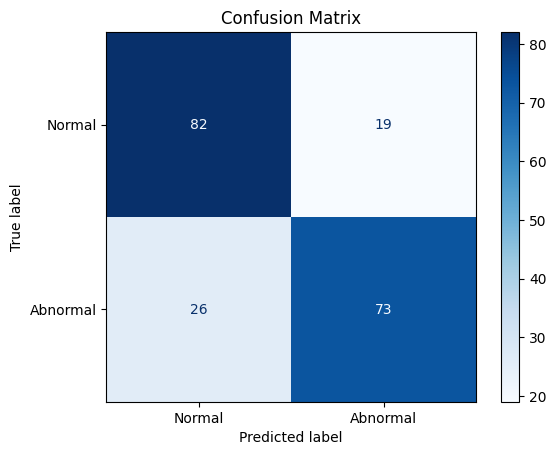

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])

plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [10]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Pastikan model dan checkpoint sudah diload:
model = VAE_Classifier(latent_dim=512, num_classes=2)
checkpoint = torch.load("best_model_resnet50_checkpoint.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Evaluasi ulang di test_loader (atau val_loader)
val_loss, val_acc, val_prec, val_rec, val_f1, val_labels, val_preds = validate(model, test_loader)

# Konversi ke list int
val_labels = np.array(val_labels).astype(int).tolist()
val_preds = np.array(val_preds).astype(int).tolist()

# Cetak classification report
print("\n===> Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["class_0", "class_1"], zero_division=0))

print("Accuracy Score:", accuracy_score(val_labels, val_preds))
print(f"Val F1-score  :", val_f1)


flatten_dim: 2304


Validation:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\BDSRC\AppData\Local\Temp\ipykernel_12820\2973061307.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 7/7 [00:21<00:00,  3.04s/it]


===> Classification Report:
              precision    recall  f1-score   support

     class_0       0.80      0.84      0.82       101
     class_1       0.83      0.79      0.81        99

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

Accuracy Score: 0.815
Val F1-score  : 0.8147730970438787
